#### Reducing Code
Milan Conrad, 2569325

In [1]:
import sys

In [2]:
from types import FunctionType

In [3]:
import inspect

In [4]:
import bookutils

In [5]:
from Debugger import Debugger

#### Collecting a Call

We start by creating an infrastructure that collects a call. The `CallCollector` class saves the first call observed in `_function`, `_args`, and `_exception` attributes, respectively; it then turns tracing off.

In [6]:
class CallCollector(object):
    """Collect an exception-raising function call f().
    Use as `with CallCollector(): f()`"""

    def __init__(self):
        """Initialize collector"""
        self.init()

    def init(self):
        """Reset for new collection."""
        self._function = None
        self._args = {}
        self._exception = None

    def traceit(self, frame, event, arg):
        """Tracing function. Collect first call, then turn tracing off."""
        if event == 'call':
            name = frame.f_code.co_name
            if name.startswith('__'):
                # Internal function
                return
            if self._function is not None:
                # Already set
                return

            if name in frame.f_globals:
                # Access exactly this function
                self._function = frame.f_globals[name]
            elif name in frame.f_locals:
                self._function = frame.f_locals[name]
            else:
                # Create new function from given code
                self._function = FunctionType(frame.f_code,
                                              globals=frame.f_globals,
                                              name=name)

            self._args = {}  # Create a local copy of args
            for var in frame.f_locals:
                self._args[var] = frame.f_locals[var]

            # Turn tracing off
            sys.settrace(self.original_trace_function)
        
    def call(self, new_args={}):
        """Call collected function. If new_args is given,
        override arguments from its {var: value} entries."""
        args = {}  # Create local copy
        for var in self.args():
            args[var] = self.args()[var]
        for var in new_args:
            args[var] = new_args[var]

        return self.function()(**args)
    
    def format_call(self, args=None):
        """Return a string representing a call of the function with given args."""
        if args is None:
            args = self.args()
        return self.function().__name__ + "(" + \
            ", ".join(f"{arg}={repr(args[arg])}" for arg in args) + ")"

    def format_exception(self, exc=None):
        """Return a string representing the given exception."""
        if exc is None:
            exc = self.exception()
        s = type(exc).__name__
        if str(exc):
            s += ": " + str(exc)
        return s

    def after_collection(self):
        """Called after collection. To be defined in subclasses."""
        pass

    def args(self):
        """Return the dictionary of collected arguments."""
        return self._args

    def function(self):
        """Return the function called."""
        return self._function

    def exception(self):
        """Return the exception produced."""
        return self._exception

    def __enter__(self):
        """Called at begin of `with` block. Turn tracing on."""
        self.init()
        self.original_trace_function = sys.gettrace()
        sys.settrace(self.traceit)
        return self

    def __exit__(self, exc_type, exc_value, traceback):
        """Called at end of `with` block. Turn tracing off."""
        sys.settrace(self.original_trace_function)
        if self._function is None:
            return False  # Re-raise exception, if any

        self._exception = exc_value
        self.after_collection()
        return True  # Ignore exception

In [7]:
def mystery(inp):
    x = inp.find(chr(0o17 + 0o31))
    y = inp.find(chr(0o27 + 0o22))
    if x >= 0 and y >= 0 and x < y:
        raise ValueError("Invalid input")
    else:
        pass

In [8]:
failing_input = 'V"/+!aF-(V4EOz*+s/Q,7)2@0_'
failing_input

'V"/+!aF-(V4EOz*+s/Q,7)2@0_'

In [9]:
from ExpectError import ExpectError

In [10]:
with ExpectError(ValueError):
    mystery(failing_input)

Traceback (most recent call last):
  File "<ipython-input-10-4e5dc18f5c4d>", line 2, in <module>
    mystery(failing_input)
  File "<ipython-input-7-26b70a4c8761>", line 5, in mystery
    raise ValueError("Invalid input")
ValueError: Invalid input (expected)


In [11]:
def generic_test(inp, fun, expected_exc=None):
    result = None
    detail = ""
    try:
        result = fun(inp)
        outcome = PASS
    except Exception as exc:
        detail = f" ({type(exc).__name__}: {str(exc)})"
        if expected_exc is None:
            outcome = FAIL
        elif type(exc) == type(expected_exc) and str(exc) == str(expected_exc):
            outcome = FAIL
        else:
            outcome = UNRESOLVED

    print(f"{fun.__name__}({repr(inp)}): {outcome}{detail}")
    return outcome

In [12]:
PASS = 'PASS'
FAIL = 'FAIL'
UNRESOLVED = 'UNRESOLVED'

In [13]:
with CallCollector() as call_collector:
    mystery(failing_input)

In [14]:
call_collector.function()

<function __main__.mystery(inp)>

In [15]:
call_collector.args()

{'inp': 'V"/+!aF-(V4EOz*+s/Q,7)2@0_'}

In [16]:
call_collector.exception()

ValueError('Invalid input')

We first introduce a `CallReducer` class as an abstract superclass for all kinds of reducers.
Its `run()` method tests the function and returns PASS, FAIL, or UNRESOLVED. As with `generic_test()`, above, we check for exception type and exact error message.

In [17]:
class CallReducer(CallCollector):
    def __init__(self, log=False):
        """Initialize. If log is True, enable logging."""
        super().__init__()
        self.log = log
        self.reset()

    def reset(self):
        """Reset the number of tests."""
        self.tests = 0

    def run(self, args):
        """Run collected function with args. Return
        * PASS if no exception occurred
        * FAIL if the collected exception occurred
        * UNRESOLVED if some other exception occurred.
        Not to be used directly; can be overloaded in subclasses.
        """
        try:
            result = self.call(args)
        except Exception as exc:
            self.last_exception = exc
            if (type(exc) == type(self.exception()) and
                    str(exc) == str(self.exception())):
                return FAIL
            else:
                return UNRESOLVED  # Some other failure

        self.last_result = result
        return PASS

In [18]:
class CachingCallReducer(CallReducer):
    """Like CallReducer, but cache test outcomes."""

    def init(self):
        super().init()
        self._cache = {}

    def test(self, args):
        # Create a hashable index
        try:
            index = frozenset((k, v) for k, v in args.items())
        except TypeError:
            index = None

        if index is None:
            # Non-hashable value – do not use cache
            return super().test(args)

        if index in self._cache:
            return self._cache[index]

        outcome = super().test(args)
        self._cache[index] = outcome

        return outcome

In [19]:
def compile_and_run(lines):
    exec("".join(lines), {}, {})

In [20]:
import ast
import astor
from bookutils import show_ast
import copy
from Assertions import remove_html_markup
from bookutils import print_content

In [21]:
fun_source = inspect.getsource(remove_html_markup)

In [22]:
print_content(fun_source, '.py')

def remove_html_markup(s):
    tag = False
    quote = False
    out = ""

    for c in s:
        if c == '<' and not quote:
            tag = True
        elif c == '>' and not quote:
            tag = False
        elif c == '"' or c == "'" and tag:
            quote = not quote
        elif not tag:
            out = out + c

    # postcondition
    assert '<' not in out and '>' not in out

    return out

In [23]:
fun_tree = ast.parse(fun_source)

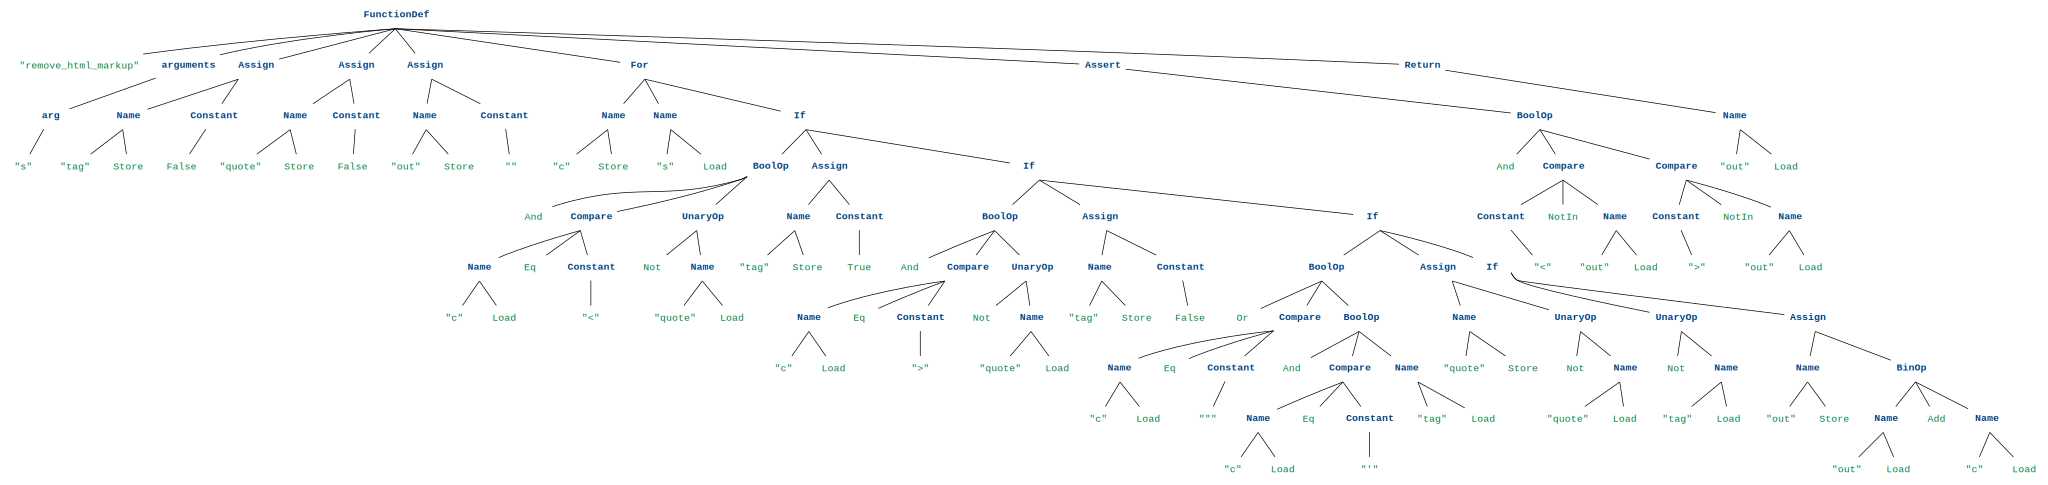

In [24]:
show_ast(fun_tree)

#### Traversing Syntax Trees

Our goal is now to reduce this tree (or at least the subtree with the function definition) to a minimum. 
To this end, we manipulate the AST through the Python modules `ast` and `astor`. The [official Python `ast` reference](http://docs.python.org/3/library/ast) is complete, but a bit brief; the documentation ["Green Tree Snakes - the missing Python AST docs"](https://greentreesnakes.readthedocs.io/en/latest/) provides an excellent introduction.

###### The two means for exploring and changing ASTs are the classes `NodeVisitor` and `NodeTransformer`, respectively. We start with creating a list of all nodes in the tree, using a `NodeVisitor` subclass.

Its `visit()` method is called for every node in the tree, which we achieve by having it return `self.generic_visit()` for the current node. It saves all visited nodes in the `_all_nodes` attribute.

In [25]:
from ast import NodeTransformer, NodeVisitor, fix_missing_locations

In [26]:
class NodeCollector(NodeVisitor):
    """Collect all nodes in an AST."""
    all_nodes = list()
    def __init__(self):
        super().__init__()
        self._all_nodes = []

    def generic_visit(self, node):
        self._all_nodes.append(node) 
        #print('generic_visit of ' + str(type(node)))
        return super().generic_visit(node)

    def collect(self, tree):
        """Return a list of all nodes in tree."""
        self._all_nodes = []
        self.visit(tree)
        return self._all_nodes
    
    def get_num_nodes(self):
        return len(self.all_nodes)
    
    def collect_on_depth(self,tree,depth):
        
        result = list()
        
        if self.all_nodes == []:
            self.all_nodes = self.collect(tree)
        
        for node in self.all_nodes:
            if node.depth == depth:
                result.append(node)
        
        return result

In [27]:
fun_nodes = NodeCollector().collect(fun_tree)

#### Deleting Nodes

In our next step, we write some code that, given such a list of nodes, _prunes_ the tree such that _only_ elements in the list are still contained. To this end, we proceed in four steps:

1. We traverse the original AST, _marking_ all nodes as "to be deleted".
2. We traverse the given list of nodes, clearing their markers.
3. We copy the original tree (including the markers) into a new tree – the one to be reduced.
4. We traverse the new tree, now deleting all marked nodes.

Why do we go through such an extra effort? The reason is that our list of nodes contains references into the _original_ tree – a tree that needs to stay unchanged such that we can reuse it for later. The new tree (the copy) has the same nodes, but at different addresses, so our original references cannot be used anymore. Markers, however, just like any other attributes, are safely copied from the original into the new tree.

The `NodeMarker()` visitor marks all nodes in a tree:

In [28]:
class NodeMarker(NodeVisitor):
    def __init__(self):
        super().__init__()
    
    def visit(self, node):
        node.marked = True
        if(not hasattr(node, 'top_level')):
            node.top_level = False
        return super().generic_visit(node)


The NodeReducer() transformer reduces all marked nodes. If a method visit_<node class>() is defined, it will be invoked; otherwise, visit_Node() is invoked, which deletes the node (and its subtree) by returning None. 

In [29]:
class NodeReducer(NodeTransformer):
    PASS_TREE = ast.parse("pass").body[0]
    FALSE_TREE = ast.parse("False").body[0].value
    empty_function = "def placeholder(): return None"
    EMPTY_FUNCTION_TREE = ast.parse(empty_function)
    
    def __init__(self):
        super().__init__()
    
    def visit(self, node):
        method = 'visit_' + node.__class__.__name__
        visitor = getattr(self, method, self.visit_Node)
        return visitor(node)
        
    def visit_Module(self, node):
        # Can't remove modules
        return super().generic_visit(node)

    def visit_Node(self, node):
        """Default visitor for all nodes"""
        if node.marked:
            return None  # delete it
        return super().generic_visit(node)

Our function `copy_and_reduce()` puts these two pieces together: It marks all cells and delete all cells except for those in the keep list

In [30]:
def copy_and_reduce(tree, keep_list):
    """Copy tree, reducing all nodes that are not in keep_list."""

    # Mark all nodes except those in keep_list
    NodeMarker().visit(tree)
    for node in keep_list:
        # print("Clearing", node)
        node.marked = False

    # Copy tree and delete marked nodes
    new_tree = copy.deepcopy(tree)
    NodeReducer().visit(new_tree)
    return new_tree

#### Reducing Trees

We can put all these steps together in a single function. `compile_and_test_ast()` takes a tree and a list of nodes, reduces the tree to those nodes in the list, and then compiles and runs the reduced AST.

In [31]:
def compile_and_test_ast(tree, keep_list, test_tree=None):
    new_tree = copy_and_reduce(tree, keep_list)
    # print(astor.to_source(new_tree))

    if test_tree is not None:
        new_tree.body += test_tree.body

    try:
        code_object = compile(new_tree, '<string>', 'exec')
    except Exception:
        raise SyntaxError("Cannot compile")

    exec(code_object, {}, {})

In [32]:
#fun_nodes

In [33]:
astor.to_source(fun_nodes[4])

'tag = False\n'

In [34]:
keep_list = fun_nodes.copy()
del keep_list[4]
new_fun_tree = copy_and_reduce(fun_tree, keep_list)

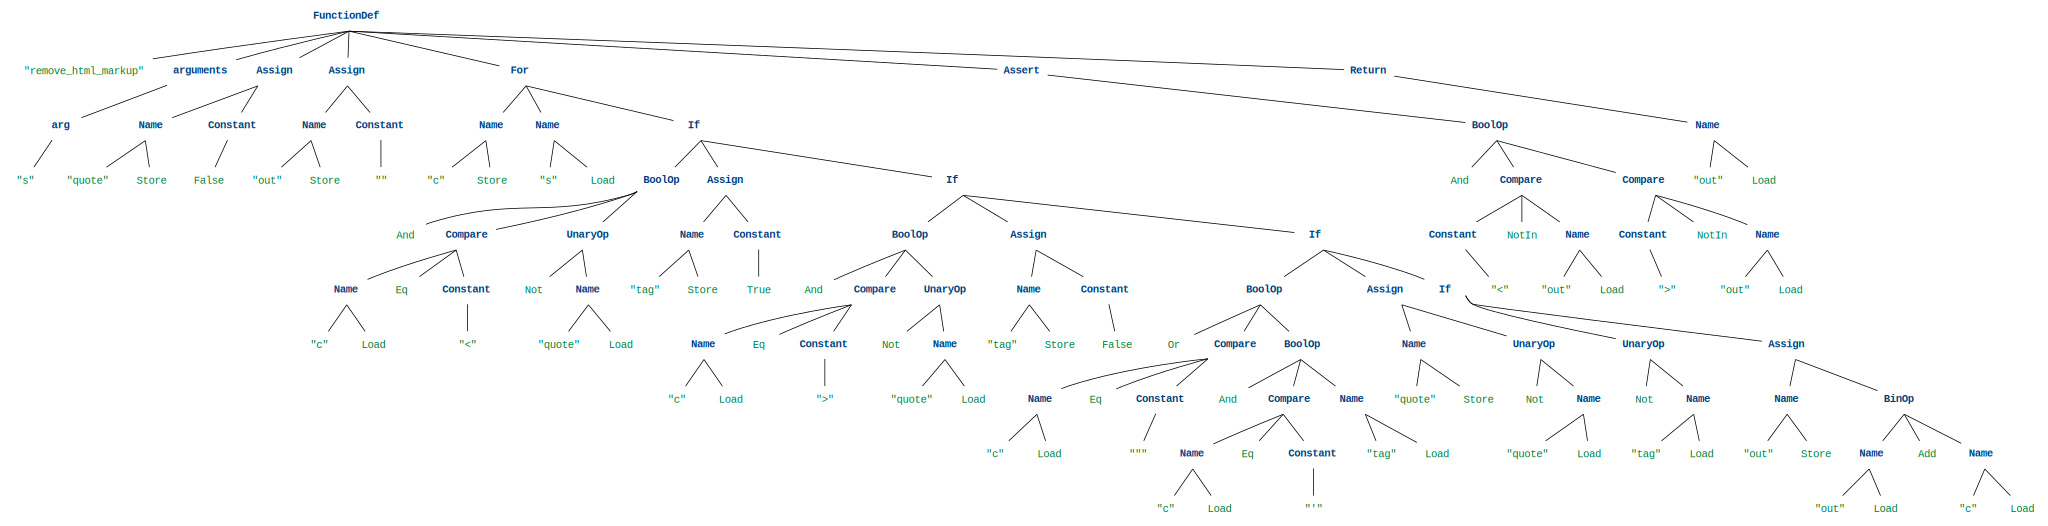

In [35]:
show_ast(new_fun_tree)

In [36]:
test_source = (
    '''if remove_html_markup('<foo>bar</foo>') != 'bar':\n''' +
    '''    raise RuntimeError("Missing functionality")\n''' +
    '''assert remove_html_markup('"foo"') == '"foo"', "My Test"''')

In [37]:
test_tree = ast.parse(test_source)

In [38]:
#show_ast(test_tree)

In [39]:
print_content(astor.to_source(test_tree), '.py')

if remove_html_markup('<foo>bar</foo>') != 'bar':
    raise RuntimeError('Missing functionality')
assert remove_html_markup('"foo"') == '"foo"', 'My Test'

## Parsers

In [40]:
class ParserException(Exception):
    pass

In [41]:
class Parser(ast.NodeVisitor):
    """The base class for a parser"""
    def parse_tree(self, tree):
        self.visit(tree)

    def parse(self, source):
        tree = ast.parse(source=source)
        self.parse_tree(tree)
        return "The input was successfully parsed."

In [42]:
class Parser1(Parser):
    """
    Contains boolean operation
    """    
    def visit_BoolOp(self, node):
        raise ParserException(f"Something went wrong")

In [43]:
class Parser2(Parser):
    """
    Fails if an input program contains `if` statement
    """
    def visit_If(self, node):
        raise ParserException(f"Something went wrong")

In [44]:
class Parser3(Parser):
    """
    Fails if an input program contains a special unicode character
    """
    def __init__(self) -> None:
        self.assignment = False
        self.steps = 0

    def check_unicode(self, string):
        return string == u'\u0426'

    def generic_visit(self, node):
        self.steps += 1
        super().generic_visit(node)

    def visit_Assign(self, node):
        self.assignment = True
        self.steps = 0
        self.generic_visit(node)

    def visit_Str(self, node):
        if self.assignment and self.steps == 3:
            if self.check_unicode(node.s):
                raise ParserException(f"Something went wrong")

In [45]:
class Parser4(Parser):
    """
    Fails if an input program contains a variable which is not defined
    """
    def __init__(self) -> None:
        self.assignment = False
        self.steps = 0
        self.variables = set()

    def generic_visit(self, node):
        self.steps += 1
        super().generic_visit(node)

    def visit_Name(self, node):
        if self.assignment and self.steps == 1:
            self.variables.add(node.id)
            self.assignment = False
            self.generic_visit(node)
        elif node.id in self.variables:
            self.generic_visit(node)
        else:
            raise ParserException(f"Something went wrong")

    def visit_Assign(self, node):
        self.assignment = True
        self.steps = 0
        self.generic_visit(node)

In [46]:
class Parser5(Parser):
    """
    Fails if an input program contains a list
    """

    def visit_List(self, node):
        raise ParserException(f"Something went wrong")

## Tests

In [47]:
class Test1:
    parser = Parser1()

    def get_original(self):
        return '''
def original():
    a = True
    b = not False
    c = 30
    for i in range(c):
        if i == 15:
            if a and b:
                return 1
    return 0
'''

    def get_minimized(self):
        return '''
True and True'''

In [48]:
class Test2:
    parser = Parser2()
    def get_original(self):
        return '''
def original():
    a = True
    b = not False
    c = 30
    for i in range(c):
        if i == 15:
            if a and b:
                return 1
    return 0
    '''

    def get_minimized(self):
        return '''
if True:
    return
'''

In [49]:
class Test3:
    parser = Parser3()
    def get_original(self):
        return '''
def original():
    a = 1
    b = a
    c = a - b
    if c < a:
        d = ''
        while a == b:
            d = u'\u0426'
            a += 1
        return d
    return ''
'''

    def get_minimized(self):
        return '''
d = u'\u0426'
'''

In [50]:
class Test4:
    parser = Parser4()
    def get_original(self):
        return '''
def original():
    a = 1
    b = a
    c = a - b
    if c < a:
        while a == b:
            a += 1
        return d
    return ''
'''

    def get_minimized(self):
        return '''
d
'''

In [51]:
class Test5:
    parser = Parser5()

    def get_original(self):
        return '''
def original():
    a = 1
    b = 0
    while True:
        if a < b:
            return [1, 2, 3]
        else:
            return []
'''

    def get_minimized(self):
        return '''
[]
'''

## Testing Framework

In [52]:
class NodeCounter(ast.NodeVisitor):
    """
    This node counter is used to assess the amount of reductions performed by your reducer. It counts the number of nodes in the AST
    """

    def __init__(self) -> None:
        self.num_nodes = 0

    def visit(self, node):
        self.num_nodes += 1
        self.generic_visit(node)

    def count(self, source):
        tree = ast.parse(source=source)
        self.visit(tree)
        return self.num_nodes

In [53]:
class TestingFramework:
    THRESHOLD = 3
    test_cases = {
        'test1': Test1(),
        'test2': Test2(),
        'test3': Test3(),
        'test4': Test4(),
        'test5': Test5()
    }
    def __init__(self, reducer):
        self.reducer = reducer

    def count_nodes(self, source):
        if source is None:
            return 100000
        return NodeCounter().count(source)

    def run_test(self, test):
        """
        run a single test
        """
        print(f'Running test {test.__class__.__name__}')
        reducer = self.reducer(test.parser)
        reduced_code = reducer.minimize(test.get_original())
        return self.has_property(reduced_code, test.parser) and self.is_minimized(reduced_code, test.get_minimized())

    def run_tests(self):
        """
        run all public tests
        """
        passed_tests = 0
        for test in self.test_cases.values():
            success = self.run_test(test)
            if success:
               passed_tests += 1
        print(f"In total {passed_tests} tests passed")

    def has_property(self, source, parser):
        """returns True if the parser fails to parse the source"""
        try:            
            parser.parse(source)
            print(f'HAS PROPERTY: FAIL')
            return False
        except ParserException:
            print(f'HAS PROPERTY: OK')
            return True
        except Exception as e:
            print(f'HAS PROPERTY: FAIL {e}')
            return False

    def is_minimized(self, reduced, reference):
        """returns True if the AST of the reduced code contains no more then the number of nodes in the reference + a THRESHOLD"""
        count_minimized = self.count_nodes(reduced)
        count_reference = self.count_nodes(reference)
        if count_minimized <= count_reference + self.THRESHOLD:
            print(f'IS MINIMIZED: OK')
            return True
        else:
            print(f'IS MINIMIZED: FAIL')
            return False

### Delta Debuggin Algorithm

In [54]:
def ddmin(test, inp, *test_args):
    """Reduce the input inp, using the outcome of test(fun, inp)."""
    assert test(inp, *test_args) != PASS

    n = 2     # Initial granularity
    while len(inp) >= 2:
        start = 0
        subset_length = len(inp) / n
        some_complement_is_failing = False

        while start < len(inp):
            complement = inp[:int(start)] + \
                inp[int(start + subset_length):]

            if test(complement, *test_args) == FAIL:
                inp = complement
                n = max(n - 1, 2)
                some_complement_is_failing = True
                break

            start += subset_length

        if not some_complement_is_failing:
            if n == len(inp):
                break
            n = min(n * 2, len(inp))

    return inp

To see how `ddmin()` works, let us run it on our failing input. We need to define a `test` function that returns PASS or FAIL, depending on the test outcome. This `generic_test()` assumes that the function fails if it raises an exception (such as an `AssertException`), and passes otherwise. The optional argument `expected_exc` specifies the name of exception to be checked for; this ensures we reduce only for the kind of error raised in the original failure.

In [55]:
def generic_test(inp, fun, expected_exc=None):
    result = None
    detail = ""
    try:
        result = fun(inp)
        outcome = PASS
    except Exception as exc:
        detail = f" ({type(exc).__name__}: {str(exc)})"
        if expected_exc is None:
            outcome = FAIL
        elif type(exc) == type(expected_exc) and str(exc) == str(expected_exc):
            outcome = FAIL
        else:
            outcome = UNRESOLVED

    print(f"{fun.__name__}({repr(inp)}): {outcome}{detail}")
    return outcome

In [56]:
def split(elems, n):
    if(not (1 <= n <= len(elems))): return {}

    k, m = divmod(len(elems), n)
    try:
        subsets = list(elems[i * k + min(i, m):(i + 1) * k + min(i + 1, m)]
                       for i in range(n))
    except TypeError:
        # Convert to list and back
        subsets = list(type(elems)(
                    list(elems)[i * k + min(i, m):(i + 1) * k + min(i + 1, m)])
                       for i in range(n))

    assert len(subsets) == n
    assert sum(len(subset) for subset in subsets) == len(elems)
    assert all(len(subset) > 0 for subset in subsets)

    return subsets

In [57]:
def add_to(collection, elem):
    """Add element to collection; return new collection."""
    if isinstance(collection, str):
        return collection + elem  # Strings

    try:  # Lists and other collections
        return collection + type(collection)([elem])
    except TypeError:
        pass

    try:  # Sets
        return collection | type(collection)([elem])
    except TypeError:
        pass

    raise ValueError("Cannot add element to collection")

In [58]:
def from_set(the_set, inp):
    """Convert a set of indices into inp back into a collection."""
    ret = empty(inp)
    for i, c in enumerate(inp):
        if i in the_set:
            ret = add_to(ret, c)
    return ret

In [59]:
def to_set(inp):
    """Convert inp into a set of indices"""
    return set(range(len(inp)))

In [60]:
 def ret(c_pass, c_fail):
            return (from_set(c_pass, c_fail),
                    from_set(c_fail, c_fail),
                    from_set(c_fail - c_pass, c_fail))

# Begin of my Code
Implementing the HDD Approach, which is shown in a Paper of the Background Section

In [61]:
class InverseNodeMarker(NodeVisitor):
    def __init__(self):
        super().__init__()
        
    def visit(self, node):
        node.marked = False
        return super().generic_visit(node)

In [62]:
class DepthMarker(NodeTransformer):
    current_depth = None
    def __init__(self):
        super().__init__()
        self.current_depth = 0
        self.max_depth = 0
            
    def visit(self, node):     
        """Default visitor for all nodes"""
        node.depth = self.current_depth
        self.current_depth += 1
        if self.current_depth > self.max_depth:
            self.max_depth = self.current_depth
        result =  super().generic_visit(node)
        self.current_depth -= 1
        return result

In [63]:
class TemplateReducer(NodeTransformer):
    
    PASS_TREE = ast.parse("pass").body[0]
    FALSE_TREE = ast.parse("False").body[0].value
    empty_function = "def placeholder(): return None"
    EMPTY_FUNCTION_TREE = ast.parse(empty_function)
    last_index = 0
    
    def __init__(self):
        super().__init__()
        self.last_index = 0
        
    def set_num_nodes(self, num_nodes):
        self.last_index = num_nodes
    
    def visit(self, node):
        method = 'visit_' + node.__class__.__name__
        visitor = getattr(self, method, self.visit_Node)
        return visitor(node)
    
    def visit_Constant(self, node):
        result = list()
        result.append(node)
        return result

    def visit_While(self,node):
         #Replace by body 
        result = list()
        result.append(node.body)
        return result
    
    def visit_For(self, node):
        #Replace by body 
        result = list()
        result.append(node.body)
        return result
    
    def visit_FunctionDef(self, node):
        # Not sure if we can remove function_def
        result = list()
        result.append(node.body)
        return result
    
    def visit_Compare(self, node):
        result = list()
        result.append(self.FALSE_TREE)
        return result
    
    def visit_Module(self, node):
        # Can't remove modules
        result = list()
        result.append(super().generic_visit(node))
        return result
    
    def visit_BoolOp(self, node):
        result = list()
        result.append(node.values[0])
        result.append(node.values[1])
    
    def visit_Return(self,node):
        result = list()
        substitute = ast.Expr(node.value)
        self.last_index += 1
        substitute.index = self.last_index
        result.append(substitute)
        return result
    
    def visit_Assign(self, node):
        result = list()
        result.append(node.targets)
        substitute = ast.Expr(node.value)
        self.last_index += 1
        substitute.index = self.last_index
        result.append(substitute)
        return result
    
    def visit_If(self,node):
        result = list()
        condition_expression = ast.Expr(node.test)
        self.last_index += 1
        condition_expression.index = self.last_index
        result.append(condition_expression)
        result.append(node.body)
        result.append(node.orelse)
        return result   
            
    def visit_Node(self, node):
        """Default visitor for all nodes"""
        result = list()
        result.append(node)
        return result
    


In [64]:
class SubstitutionApplyer(NodeTransformer):
    def __init__(self):
        super().__init__()
        self.subst_vars = dict()
    
    def add_substitution(self,node_index,substitution):
        self.subst_vars.update({node_index:substitution})
        
    def finished_substitution(self):
        self.subst_vars = dict()
    
    def visit(self, node):
        method = 'visit_' + node.__class__.__name__
        visitor = getattr(self, method, self.visit_Node)
        return visitor(node)
    
    def visit_Node(self, node):
        """Default visitor for all nodes"""
        if node.index in self.subst_vars:
            print("FOUND SUBSTITUTION: Substitute "+str(node) +' with '+str(self.subst_vars[node.index]))
            return self.subst_vars[node.index]
        return super().generic_visit(node)
    

In [65]:
class MyHDDDebugger(CachingCallReducer):

    def __init__(self, parser):
        """
        We initialize the DebuggingReducer with a parser, as this is needed to verify whether the failure is still triggered after the code transformation
        """
        self.parser = parser
        self.node_reducer = NodeReducer()
        self.node_marker = NodeMarker()
        self.node_substitutor = TemplateReducer()
        self.substitution_applyer = SubstitutionApplyer()
        self.node_collector = NodeCollector()
        
    def compute_transformations(self,tree):
        """
        Realizes Deletion Template of Algorithm 1
        """
        tree.top_level = True
        print("Marked "+ str(tree)+ "as top level")
        candidates = list()
        print("Children indices: ")
        for child in ast.iter_child_nodes(tree):
            print(child.index)
            child.top_level = True
            print("Marked "+ str(child)+ "as top level")
            candidates.append(child)

        return candidates
    
    def has_property(self, code):
        """returns True if the parser fails to parse the source"""
        try:
            compile(ast.parse(code), "<string>", 'exec')
            print_content(code, '.py')
            self.parser.parse(code)
            print(f'HAS PROPERTY: FAIL')
            return False
        except ParserException:
            print(f'HAS PROPERTY: OK')
            return True    
        except Exception as e:
            print(f'HAS PROPERTY: FAIL {e}')
            return False
        
        try:
            self.parser.parse(code)
            print(f'HAS PROPERTY: FAIL')
            return False
        except ParserException:
            print(f'HAS PROPERTY: OK')
            return True
        except Exception as e:
            print(f'HAS PROPERTY: FAIL {e}')
            return False
    
    def test_property(self, tree, templates, indexset):
        print("Tested property with "+str(indexset)+" as indices of subtrees to keep")
        #TODO : Eventuell indexset als keep list halten NATÜRLICH; WIR WOLLEN DEN ERROR KEEPEN
        
        templates_to_remove = set()
        templates_to_remove_indices = to_set(templates) - indexset
        for index in templates_to_remove_indices:
        #    print(str(index)+': '+str(templates[index]))
            templates_to_remove.add(templates[index])
        print('Test of removing the following indices: '+str(templates_to_remove_indices))
        testing_tree = copy.deepcopy(tree)
        changed_tree = self.apply_templates(testing_tree,templates_to_remove)
        ast.fix_missing_locations(changed_tree)
        changed_tree_code = astor.to_source(changed_tree)
        test_result = self.has_property(changed_tree_code)
        print('\nEnd of test\n')
        return (test_result,changed_tree)
        
    def generalized_tree_reduction(self, tree, templates):
        """
        GTR Algorithm, Algorithm 2
        """
        if(len(templates)>=2):
            last_tree = None 
            n = 2 #Initial granularity
            offset = 0
            c_fail = to_set(templates)
            c_pass = to_set([])
            splitted_templates = split(templates,n)
            
            while True:
                delta = c_fail - c_pass
                deltas = split(delta,n)
                if(deltas == {}):
                    (minimized_property,minimized_tree) = self.test_property(tree, templates, c_fail)
                    print("Applied Deletion templates")
                    return minimized_tree
                j = 0
                while j<n:
                    i = (j + offset) % n
                    next_c_pass = c_pass | deltas[i]
                    next_c_fail = c_fail - deltas[i]
                    (c_pass_property,c_pass_tree) = self.test_property(tree, templates, next_c_pass)
                    (c_fail_property,c_fail_tree) = self.test_property(tree, templates, next_c_fail)
                    if n==2 and c_pass_property:
                        print("Reduce to subset")
                        c_fail = next_c_pass
                        last_tree = c_pass_tree
                        offset = 0
                        break
                    elif c_fail_property:
                        print("Reduce to complement")
                        c_fail = next_c_fail
                        last_tree = c_fail_tree
                        n = max(n-1,2)
                        offset = i
                        break
                    else:
                        j+=1
                if j>=n:
                    if n>=len(delta):
                        return ret(c_pass, c_fail)
                    n = min(n+2, len(delta))

                    n = 2     # Initial granularity

        else:
            for template in templates:
                print(template)
                new_tree = self.apply_template(tree, template)
                if(self.has_property(astor.to_source(new_tree))):
                    tree = new_tree
                
            print("Applied Deletion templates")
            return tree
    
        
    def apply_substitution_templates(self,tree,level):
        tree.top_level = True
        level_nodes = self.node_collector.collect_on_depth(tree,level)
        
        copied_tree = copy.deepcopy(tree)
        for subtree in level_nodes:
            subtree.top_level = True
            subtree.marked = True
            possible_replacements = self.node_substitutor.visit(subtree)
            
            if (possible_replacements is None):
                continue
                
            for substitution in possible_replacements:
                self.substitution_applyer.add_substitution(subtree.index,substitution)
                self.substitution_applyer.visit(copied_tree)
                if(self.has_property(astor.to_source(copied_tree))):
                    tree = copied_tree
                    break #TODO: Alle ausprobieren und billigste holen
                else:
                    copied_tree = tree
        
        tree = copied_tree
        ast.fix_missing_locations(tree)
 
        self.substitution_applyer.finished_substitution()
        print("Applied Substitution templates")

        return tree
    
    def apply_templates(self, tree, templates):
        fun_nodes = self.node_collector.collect(tree)

        for node in fun_nodes:
            node.marked = False
        
        for template in templates:
            self.node_marker.visit(template)
        
        new_tree = copy.deepcopy(tree)
        self.node_reducer.visit(new_tree)
        ast.fix_missing_locations(new_tree)
        
        return new_tree
    
    def apply_template(self, tree, template):
        """
        Part of Algorithm 2
        Since we currently only use the deletion template, the subnodes of our template are marked for deletion
        """
        fun_nodes = self.node_collector.collect(tree)

        for node in fun_nodes:
            node.marked = False
            
        self.node_marker.visit(template)
        new_tree = copy.deepcopy(tree)
        self.node_reducer.visit(new_tree)
        ast.fix_missing_locations(new_tree)
    
        return tree
    
    def reduce_level_nodes(self, level_nodes, oracle, templates):
        """
        Algorithm 3
        """
        pass
    
    def get_tree_depth(self,tree):
        current_depth = 0
        return current_depth
    
    def get_tree_size(self,tree):
        """
        In the notion of the GTR Paper, the size of a tree is the number of its nodes
        """
        nodes = self.node_collector.collect(tree)
        num_nodes = len(nodes)
        return num_nodes
    
    def GTR_rec(self, tree, oracle):
        """
        Recursive Application of Generalized Tree Reduction (GTR) Algorithm, Algorithm 4
        """
        after_delete_template_tree = None
        after_substitution_tree = None
        
        fun_nodes = self.node_collector.collect(tree)
        depth_marker = DepthMarker()
        depth_marker.visit(tree)
        counter = 0
        for node in fun_nodes:
            node.index = counter
            counter += 1         
        
        max_depth = depth_marker.max_depth
        
        old_num_nodes = self.node_collector.get_num_nodes()
        new_num_nodes = old_num_nodes + 1 #To ensure at least one iteration
        counter = 1
        
        while(old_num_nodes != new_num_nodes):
            print("###################################")
            print("Iteration of GTR Algorithm: "+ str(counter))
            print("###################################")

            for i in range(1, max_depth):     
                print("###################################")
                print("Considered Tree Level: "+ str(i))
                print("###################################")
                copy_tree = copy.deepcopy(tree)
                level_nodes = self.node_collector.collect_on_depth(copy_tree,i)
                print(str(len(level_nodes))+" current level nodes: "+str(level_nodes))
                after_delete_template_tree = self.generalized_tree_reduction(copy_tree, level_nodes)
                depth_marker.visit(after_delete_template_tree)
                tree = self.apply_substitution_templates(after_delete_template_tree,i)
                show_ast(tree)
                depth_marker = DepthMarker()
                depth_marker.visit(tree)
                self.node_collector.collect(tree)
                
            new_num_nodes = self.node_collector.get_num_nodes()
            counter += 1
            
        return tree
    
    def minimize(self, code):
        """
        This function takes some Python code as string, reduces it using the NodeReducer defined earlier and returns the reduced program.
        """
        # Parse the code to a tree
        code_ast = ast.parse(source=code)

        ##Call GTR_rec to peform all minimization steps
        new_code_ast = self.GTR_rec(code_ast,generic_test)

        # Generate code from the reduced tree
        new_code = astor.to_source(new_code_ast)

        # Test, whether the error is still triggered by the reduced code
        try:
            self.parser.parse(new_code)
            # No exception is thrown. This means the new_code does not 
            # trigger an error anymore. Therefore, we failed in
            # reduction and return the initial code.
            return code
        except ParserException:
            # The error is still triggered. Return the reduced code
            return new_code


Running test Test1
###################################
Iteration of GTR Algorithm: 1
###################################
###################################
Considered Tree Level: 1
###################################
1 current level nodes: [<_ast.FunctionDef object at 0x7f0d55603700>]
def original():
    a = True
    b = not False
    c = 30
    for i in range(c):
        if i == 15:
            if a and b:
                return 1
    return 0HAS PROPERTY: OK
Applied Deletion templates
FOUND SUBSTITUTION: Substitute <_ast.FunctionDef object at 0x7f0d5555e820> with [<_ast.Assign object at 0x7f0d55603070>, <_ast.Assign object at 0x7f0d55603d90>, <_ast.Assign object at 0x7f0d556038e0>, <_ast.For object at 0x7f0d55603ac0>, <_ast.Return object at 0x7f0d55603ee0>]
a = True
b = not False
c = 30
for i in range(c):
    if i == 15:
        if a and b:
            return 1
return 0HAS PROPERTY: OK
Applied Substitution templates


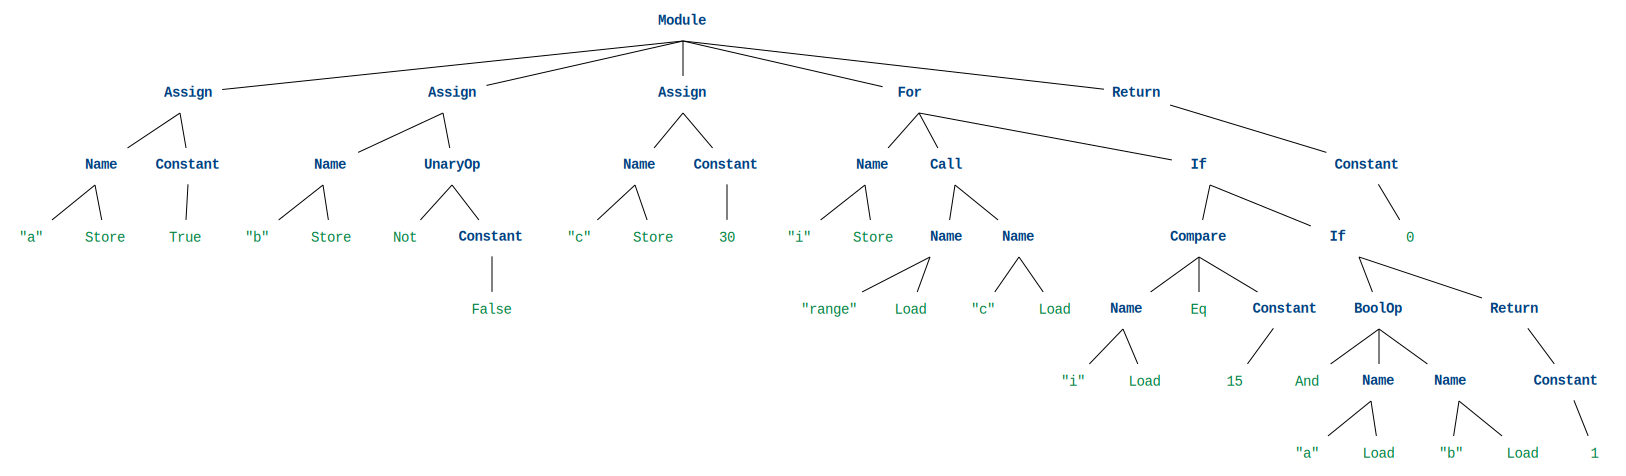

###################################
Considered Tree Level: 2
###################################
11 current level nodes: [<_ast.arguments object at 0x7f0d556039d0>, <_ast.Name object at 0x7f0d55603dc0>, <_ast.Constant object at 0x7f0d55603d60>, <_ast.Name object at 0x7f0d55603eb0>, <_ast.UnaryOp object at 0x7f0d55603e80>, <_ast.Name object at 0x7f0d556036a0>, <_ast.Constant object at 0x7f0d55603f40>, <_ast.Name object at 0x7f0d55603fa0>, <_ast.Call object at 0x7f0d55603f10>, <_ast.If object at 0x7f0d55603820>, <_ast.Constant object at 0x7f0d55603bb0>]
Tested property with {0, 1, 2, 3, 4, 5} as indices of subtrees to keep
Test of removing the following indices: {6, 7, 8, 9, 10}
a = True
b = not False
c = 30
for i in range(c):
    if i == 15:
        if a and b:
            return 1
return 0HAS PROPERTY: OK

End of test

Tested property with {6, 7, 8, 9, 10} as indices of subtrees to keep
Test of removing the following indices: {0, 1, 2, 3, 4, 5}
a = True
b = not False
c = 30
for i in ra

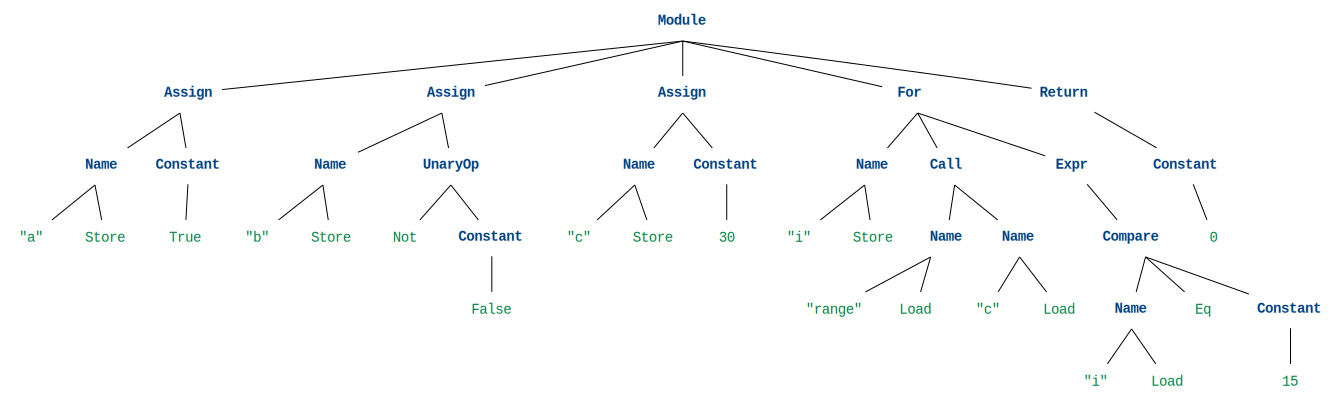

###################################
Considered Tree Level: 3
###################################
10 current level nodes: [<_ast.Store object at 0x7f0d55603b20>, <_ast.Store object at 0x7f0d55603b20>, <_ast.Not object at 0x7f0d55603fd0>, <_ast.Constant object at 0x7f0d55603f70>, <_ast.Store object at 0x7f0d55603b20>, <_ast.Store object at 0x7f0d55603b20>, <_ast.Name object at 0x7f0d55603d00>, <_ast.Name object at 0x7f0d55603910>, <_ast.Compare object at 0x7f0d556034f0>, <_ast.If object at 0x7f0d55603520>]
Tested property with {0, 1, 2, 3, 4} as indices of subtrees to keep
Test of removing the following indices: {5, 6, 7, 8, 9}
a = True
b = not False
c = 30
for i in range(c):
    i == 15
return 0HAS PROPERTY: FAIL

End of test

Tested property with {5, 6, 7, 8, 9} as indices of subtrees to keep
Test of removing the following indices: {0, 1, 2, 3, 4}
a = True
b = not False
c = 30
for i in range(c):
    i == 15
return 0HAS PROPERTY: FAIL

End of test

Tested property with {5, 6, 7, 8, 9} a

KeyboardInterrupt: 

In [66]:
tf = TestingFramework(MyHDDDebugger)
tf.run_test(Test1())